In [1]:
%matplotlib notebook 
%matplotlib notebook 

In [2]:
import warnings

warnings.simplefilter(action="ignore")

import functools
import argparse
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import gamma
import os
import time
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchnet as tnt
from sklearn.neighbors import NearestNeighbors

import gc

# from osgeo import gdal, osr  # TODO: UNCOMMENT
import torch.nn as nn
from scipy.special import digamma, polygamma

import matplotlib

# Weird behavior: loading twice in cell appears to remove an elsewise occuring error.
for i in range(2):
    try:
        matplotlib.use("TkAgg")  # rerun this cell if an error occurs.
    except:
        print("!")
import matplotlib.pyplot as plt


import pickle
from torch_scatter import scatter_max, scatter_mean

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

# We import from other files
import sys
sys.path.append("/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/")
from config import args
from model.model import PointNet
from utils.useful_functions import *
from data_loader.loader import *
from utils.load_las_data import *
from model.loss_functions import *
from model.accuracy import *
from em_gamma.get_gamma_parameters_em import *
from model.train import train_full

print("Everything is imported")


print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

False
Dataset folder in use: /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/data/
Arguments were imported in DEV mode
Everything is imported
False


## Loading single parcelle file

In [7]:
import seaborn as sns; sns.set();
from math import cos, pi, ceil
import pandas as pd

In [8]:
# Create the result folder
create_new_experiment_folder(args)  # new paths are added to args

las_folder = args.las_parcelles_folder_path
las_file = "004000715-5-18.las"
points_nparray, xy_averages = load_single_las(las_folder, las_file)
x_las, y_las = points_nparray[:,0], points_nparray[:,1]
# subsampling = points_nparray.shape[0]
subsampling = 500
subset = np.random.choice(points_nparray.shape[0],size=subsampling, replace=False)
x_las = x_las[subset]
y_las = y_las[subset]

# center the point. TODO: This should be reveserd at the end. Or centering can be done when plotting !
x_las = x_las - x_las.mean()
y_las = y_las - y_las.mean()

x_min = x_las.min()
y_min = y_las.min()
x_max = x_las.max()
y_max = y_las.max()
print(x_max-x_min, y_max-y_min)

09:25:23
Results folder:  /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/DEV/2021-06-02_11h25m23s/
74.18000000005122 90.91000000014901


In [9]:
# step 1 : map all pixels inside the parcelle at least partially
# step 2 : deal with borders
# step 3 : add an overlap of 0.625m on x / y

In [10]:
# 1) Identify centers of plots whose squares cover at least partially every pixel of the parcelle
# We consider the square included in a plot with r=10m. Formula for width of 
# the square is  W = 2 * (cos(45°) * r) since max radius in square equals r as well.
# We add an overlap of s*0.625 i.e. a pixel in currently produced plots of size 32 pix = 10

plot_radius_meters = 10
cos_of_45_degrees = cos(pi/4)
within_circle_square_width_meters = 2 * cos_of_45_degrees * plot_radius_meters
plot_diameter_in_pixels = args.diam_pix  # 32 by default
plot_diameter_in_meters = 20  # 2 * 10m
s = 3
square_xy_overlap = s * plot_diameter_in_meters/plot_diameter_in_pixels  # 0.625 by default
movement_in_meters = within_circle_square_width_meters - square_xy_overlap

print(f"Square dimensions are {within_circle_square_width_meters}m*{within_circle_square_width_meters}m" +
      f"but we move {movement_in_meters}m at a time to have {square_xy_overlap}m of overlap")

x_range_of_parcelle_in_movements = ceil((x_max - x_min)/(movement_in_meters))
y_range_of_parcelle_in_movements = ceil((y_max - y_min)/(movement_in_meters))
# print(x_range_of_parcelle_in_movements, y_range_of_parcelle_in_movements)

start_x = x_min + movement_in_meters/4
start_y = y_min + movement_in_meters/4
grid_pixel_xy_centers = [[start_x, start_y]]

for i_dx in range(x_range_of_parcelle_in_movements):
    current_x = start_x + i_dx * movement_in_meters  # move along x axis
    for i_dy in range(y_range_of_parcelle_in_movements):
        current_y = start_y + i_dy * movement_in_meters  # move along y axis
        new_plot_center = [current_x, current_y]
        grid_pixel_xy_centers.append(new_plot_center)

Square dimensions are 14.142135623730951m*14.142135623730951mbut we move 12.267135623730951m at a time to have 1.875m of overlap


<IPython.core.display.Javascript object>


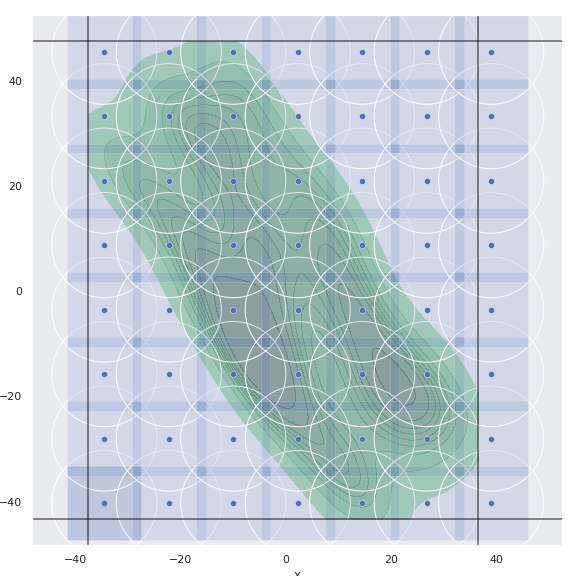

In [16]:
%matplotlib notebook
# xy to dataframe for visualization
coordinates = np.array(np.stack([x_las,y_las],axis=1))
coordinates = pd.DataFrame(data = coordinates)
coordinates.columns = ["x","y"]
# centers to dataframe for visualization
centers = np.array(grid_pixel_xy_centers)
centers = pd.DataFrame(data = centers)
centers.columns = ["x","y"]
# Sanity check visualizing the position of centers
fig, ax = plt.subplots(figsize = (8,8))
ax.grid(False)
ax.set_aspect('equal', 'box')  # Not working right now
fig.tight_layout()
sns.kdeplot(data = coordinates, x="x", y="y", fill=True, alpha=0.5, color="g", clip = [[x_min, x_max], [y_min, y_max]])  #thresh=0.2
sns.scatterplot(data = centers, x="x", y="y")
plt.xlim(min(x_min, y_min)-5, max(x_max, y_max)+5)
plt.ylim(min(x_min, y_min)-5, max(x_max, y_max)+5)
for x, y in grid_pixel_xy_centers:
    a_circle = plt.Circle((x, y), 10, fill=False)
    ax.add_patch(a_circle)
    a_square = matplotlib.patches.Rectangle((x-within_circle_square_width_meters/2, 
                                             y-within_circle_square_width_meters/2), 
                                            within_circle_square_width_meters,
                                            within_circle_square_width_meters,
                                            fill=True, alpha =0.15)
    ax.add_patch(a_square)
plt.axhline(y=y_min, xmin=x_min, xmax=x_max, color='black', alpha = 0.6, linestyle='-')
plt.axhline(y=y_max, xmin=x_min, xmax=x_max, color='black', alpha = 0.6, linestyle='-')
plt.axvline(x=x_min, ymin=y_min, ymax=y_max, color='black', alpha = 0.6, linestyle='-')
plt.axvline(x=x_max, ymin=y_min, ymax=y_max, color='black', alpha = 0.6, linestyle='-')
fig.show()

In [ ]:
41.686660+within_circle_square_width_meters/2 - y_las.max()

In [60]:
centers.max()

x    36.222366
y    41.686660
dtype: float64

# OTHER

In [9]:
# Create the result folder
create_new_experiment_folder(args)  # new paths are added to args

# Load Las files for placettes
(
    all_points_nparray,
    nparray_clouds_dict,
    xy_averages_dict,
) = load_all_las_from_folder(args.las_files_folder_path)
print("Our dataset contains " + str(len(nparray_clouds_dict)) + " plots.")

# Load ground truth csv file
# Name, 'COUV_BASSE', 'COUV_SOL', 'COUV_INTER', 'COUV_HAUTE', 'ADM'
df_gt, placettes_names = open_metadata_dataframe(
    args, pl_id_to_keep=nparray_clouds_dict.keys()
)
print(df_gt.head())

# Fit a mixture of 2 gamma distribution if not already done
z_all = all_points_nparray[:, 2]
args.z_max = np.max(
    z_all
)  # maximum z value for data normalization, obtained from the normalized dataset analysis
args.n_input_feats = len(args.input_feats)  # number of input features
print_stats(
    args.stats_file, str(args), print_to_console=True
)  # save all the args parameters
params = run_or_load_em_analysis(z_all, args)
print_stats(args.stats_file, str(params), print_to_console=True)

# We use several folds for cross validation (set the number in args)
kf = KFold(n_splits=args.folds, random_state=42, shuffle=True)

# None lists that will stock stats for each fold, so we can compute the mean at the end
all_folds_loss_train_lists = None
all_folds_loss_test_lists = None

# cross-validation
start_time = time.time()
fold_id = 1
cloud_info_list_by_fold = {}
print("Starting cross-validation")
for train_ind, test_ind in kf.split(placettes_names):
    print("Cross-validation FOLD = %d" % (fold_id))
    train_list = placettes_names[train_ind]
    test_list = placettes_names[test_ind]

    # generate the train and test dataset
    test_set = tnt.dataset.ListDataset(
        test_list,
        functools.partial(
            cloud_loader,
            dataset=nparray_clouds_dict,
            df_gt=df_gt,
            train=False,
            args=args,
        ),
    )
    train_set = tnt.dataset.ListDataset(
        train_list,
        functools.partial(
            cloud_loader,
            dataset=nparray_clouds_dict,
            df_gt=df_gt,
            train=True,
            args=args,
        ),
    )

    # TRAINING on fold
    (
        trained_model,
        final_train_losses_list,
        final_test_losses_list,
        cloud_info_list,
    ) = train_full(
        args, fold_id, train_set, test_set, test_list, xy_averages_dict, params
    )

    cloud_info_list_by_fold[fold_id] = cloud_info_list

    # save the trained model
    PATH = os.path.join(
        args.stats_path,
        "model_ss_"
        + str(args.subsample_size)
        + "_dp_"
        + str(args.diam_pix)
        + "_fold_"
        + str(fold_id)
        + ".pt",
    )
    torch.save(trained_model, PATH)

    # We compute stats per fold
    all_folds_loss_train_lists, all_folds_loss_test_lists = stats_per_fold(
        all_folds_loss_train_lists,
        all_folds_loss_test_lists,
        final_train_losses_list,
        final_test_losses_list,
        args.stats_file,
        fold_id,
        args,
    )

    print_stats(
        args.stats_file,
        "training time "
        + str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))),
        print_to_console=True,
    )
    fold_id += 1
    if args.mode == "DEV" and fold_id >= 2:
        break

stats_for_all_folds(
    all_folds_loss_train_lists, all_folds_loss_test_lists, args.stats_file, args
)

# cloud_info_list_by_fold
cloud_info_list_all_folds = [
    dict(p, **{"fold_id": fold_id})
    for fold_id, infos in cloud_info_list_by_fold.items()
    for p in infos
]
df_inference = pd.DataFrame(cloud_info_list_all_folds)
inference_path = os.path.join(args.stats_path, "PCC_inference_all_placettes.csv")
df_inference["error_veg_b"] = (
    df_inference["pred_veg_b"] - df_inference["vt_veg_b"]
).abs()
df_inference["error_veg_moy"] = (
    df_inference["pred_veg_moy"] - df_inference["vt_veg_moy"]
).abs()
df_inference.to_csv(inference_path, index=False)  # TODO: remove just in case
df_inference["error_veg_b_and_moy"] = (
    df_inference["error_veg_b"] + df_inference["error_veg_moy"]
) / 2
df_inference.to_csv(inference_path, index=False)

15:07:36
Results folder:  /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/DEV/2021-06-01_17h07m36s/


AttributeError: 'Namespace' object has no attribute 'las_files_folder_path'